In [1]:
require('rstan')
require('ggplot2')
require('reshape2')



Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.17.3, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file 'dat_30690.RData', probable reason 'No such file or directory'”

ERROR: Error in readChar(con, 5L, useBytes = TRUE): cannot open the connection


In [3]:
load("../data/biomarker/f_30690.RData")

[1] "dat"  "fit1"

Inference for Stan model: model1_no_loglik.
4 chains, each with iter=600; warmup=200; thin=1; 
post-warmup draws per chain=400, total post-warmup draws=1600.

                 mean se_mean      sd    2.5%     50%   97.5% n_eff    Rhat
Sigma[1,1]    0.00076 0.00000 0.00003 0.00071 0.00076 0.00082   728 1.00324
Sigma[1,2]    0.00063 0.00000 0.00002 0.00059 0.00063 0.00068   710 1.00259
Sigma[2,1]    0.00063 0.00000 0.00002 0.00059 0.00063 0.00068   710 1.00259
Sigma[2,2]    0.00056 0.00000 0.00002 0.00052 0.00056 0.00060   746 1.00293
pi[1]         0.98361 0.00002 0.00058 0.98246 0.98360 0.98474   820 1.00637
pi[2]         0.01639 0.00002 0.00058 0.01526 0.01640 0.01754   820 1.00637
Omegacor[1,1] 1.00000 0.00000 0.00000 1.00000 1.00000 1.00000  1600     NaN
Omegacor[1,2] 0.96460 0.00012 0.00350 0.95720 0.96468 0.97130   894 1.00106
Omegacor[2,1] 0.96460 0.00012 0.00350 0.95720 0.96468 0.97130   894 1.00106
Omegacor[2,2] 1.00000 0.00000 0.00000 1.00000 1.00000 1.00000  1600     NaN

Samp

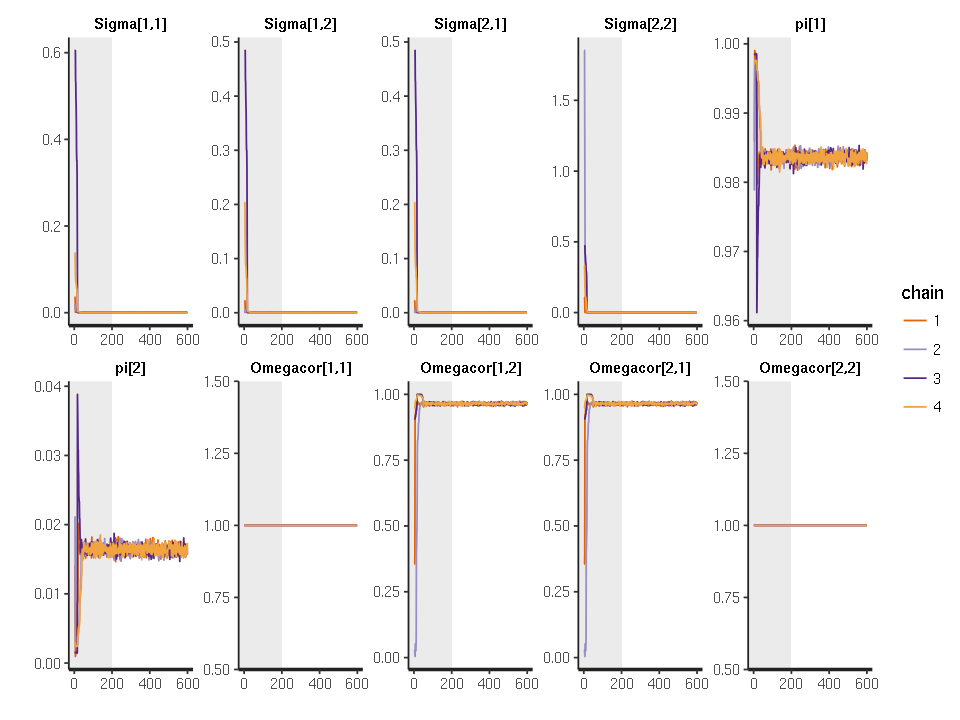

In [4]:
print(fit1, pars=c("Sigma", "pi", "Omegacor"), probs=c(0.025, 0.5, 0.975), digits_summary=5)
options(repr.plot.width=8, repr.plot.height=6)
traceplot(fit1, pars = c("Sigma", "pi", "Omegacor"), inc_warmup = TRUE, nrow = 2)


In [11]:
sum_tab <- read.delim2("../data/biomarker/summary_dat_30690_2_.txt", sep=" ", stringsAsFactors=FALSE)
m1.pi <- sum_tab[,3:4]
m1.Sigma <- sum_tab[,5:8]
m1.rg <- sum_tab[,9]
ml.rg.l <- sum_tab[,10]
ml.rg.u <- sum_tab[,11]
hf <- sum_tab[,12]
hm <- sum_tab[,13]
#(c(trait, dat$dat$N, unlist(m1.pi), unlist(m1.Sigma), unlist(rg), unlist(rg.c$l), unlist(rg.c$u), unlist(h)))


Inference for Stan model: model1_no_loglik.
4 chains, each with iter=600; warmup=200; thin=1; 
post-warmup draws per chain=400, total post-warmup draws=1600.

                 mean se_mean      sd    2.5%     50%   97.5% n_eff    Rhat
Sigma[1,1]    0.00028   0e+00 0.00002 0.00025 0.00028 0.00031   787 0.99961
Sigma[1,2]    0.00003   0e+00 0.00001 0.00001 0.00003 0.00005  1175 1.00065
Sigma[2,1]    0.00003   0e+00 0.00001 0.00001 0.00003 0.00005  1175 1.00065
Sigma[2,2]    0.00060   0e+00 0.00003 0.00054 0.00059 0.00066   674 1.00381
pi[1]         0.98419   4e-05 0.00094 0.98230 0.98421 0.98600   665 1.00069
pi[2]         0.01581   4e-05 0.00094 0.01400 0.01579 0.01770   665 1.00069
Omegacor[1,1] 1.00000   0e+00 0.00000 1.00000 1.00000 1.00000  1600     NaN
Omegacor[1,2] 0.07379   7e-04 0.02386 0.03002 0.07303 0.12178  1174 1.00100
Omegacor[2,1] 0.07379   7e-04 0.02386 0.03002 0.07303 0.12178  1174 1.00100
Omegacor[2,2] 1.00000   0e+00 0.00000 1.00000 1.00000 1.00000  1524 0.99750

Samp

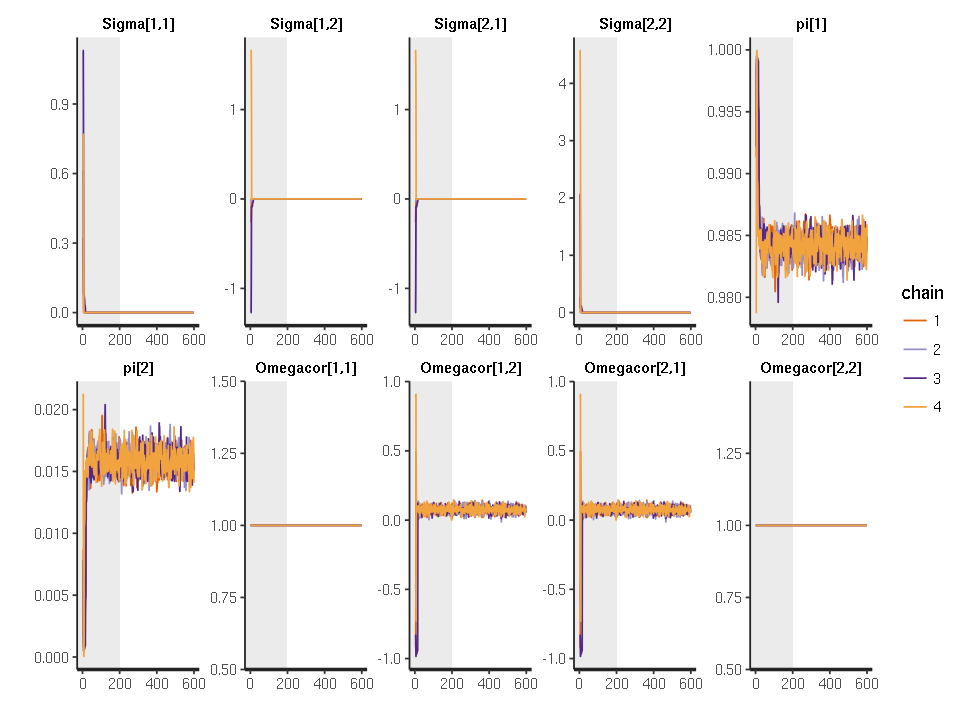

In [12]:
load("../data/biomarker/f_30850.RData")
print(fit1, pars=c("Sigma", "pi", "Omegacor"), probs=c(0.025, 0.5, 0.975), digits_summary=5)
options(repr.plot.width=8, repr.plot.height=6)
traceplot(fit1, pars = c("Sigma", "pi", "Omegacor"), inc_warmup = TRUE, nrow = 2)

Inference for Stan model: model1_no_loglik.
4 chains, each with iter=600; warmup=200; thin=1; 
post-warmup draws per chain=400, total post-warmup draws=1600.

                 mean se_mean      sd    2.5%     50%   97.5% n_eff    Rhat
Sigma[1,1]    0.00016 0.00000 0.00000 0.00016 0.00016 0.00017   925 1.00096
Sigma[1,2]    0.00017 0.00000 0.00000 0.00017 0.00017 0.00018   850 1.00073
Sigma[2,1]    0.00017 0.00000 0.00000 0.00017 0.00017 0.00018   850 1.00073
Sigma[2,2]    0.00019 0.00000 0.00000 0.00018 0.00019 0.00020   874 1.00069
pi[1]         0.91793 0.00006 0.00178 0.91445 0.91790 0.92143   816 1.00053
pi[2]         0.08207 0.00006 0.00178 0.07857 0.08210 0.08555   816 1.00053
Omegacor[1,1] 1.00000 0.00000 0.00000 1.00000 1.00000 1.00000  1600     NaN
Omegacor[1,2] 0.97953 0.00011 0.00335 0.97262 0.97962 0.98554  1006 1.00043
Omegacor[2,1] 0.97953 0.00011 0.00335 0.97262 0.97962 0.98554  1006 1.00043
Omegacor[2,2] 1.00000 0.00000 0.00000 1.00000 1.00000 1.00000  1600     NaN

Samp

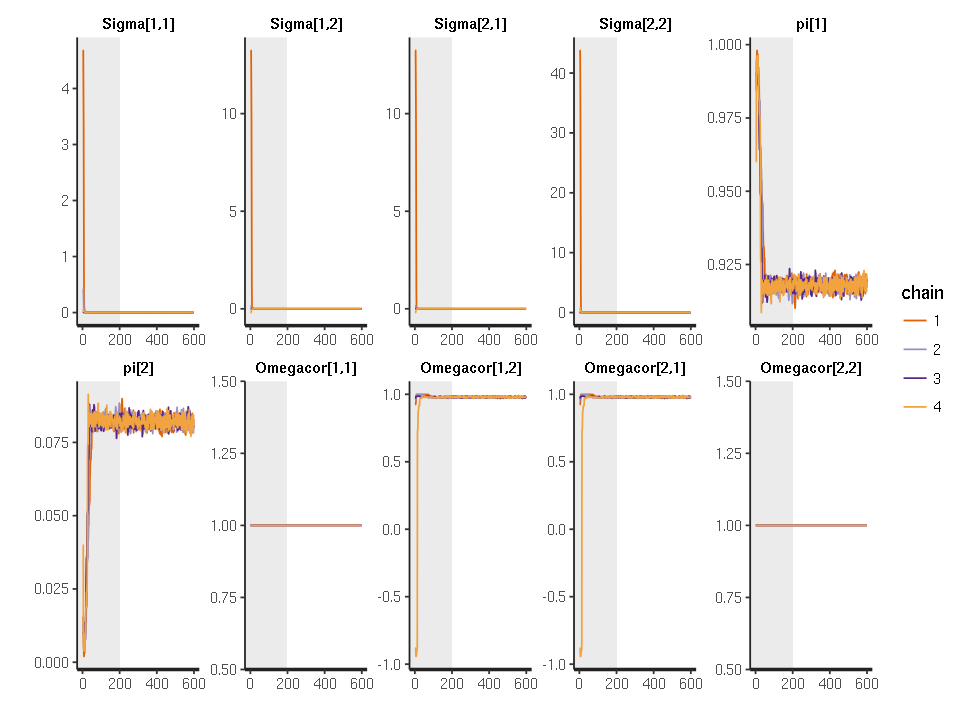

In [13]:
load("../data/biomarker/f_30750.RData")
print(fit1, pars=c("Sigma", "pi", "Omegacor"), probs=c(0.025, 0.5, 0.975), digits_summary=5)
options(repr.plot.width=8, repr.plot.height=6)
traceplot(fit1, pars = c("Sigma", "pi", "Omegacor"), inc_warmup = TRUE, nrow = 2)

In [27]:
list.traits <- c("30850", "30750", "30690")
trait.names <- c("testosterone", "hba1c", "cholesterol")
trait.df <- do.call(rbind, lapply(list.traits, function(trait) {df <- read.delim2(sprintf("../data/biomarker/summary_dat_%s_2_.txt",trait), sep=" ", stringsAsFactors=FALSE); return(df)
                                                               }))
colnames(trait.df) <-c("trait", "N", "pi[1]", "pi[2]", "Sigma[1,1]", "Sigma[1,2]", "Sigma[2,1]", "Sigma[2,2]", 
  "rg", "rg.l", "rg.u", "hf", "hm")
trait.df <- data.frame(apply(trait.df, c(1,2), as.numeric))
trait.df$names <- trait.names


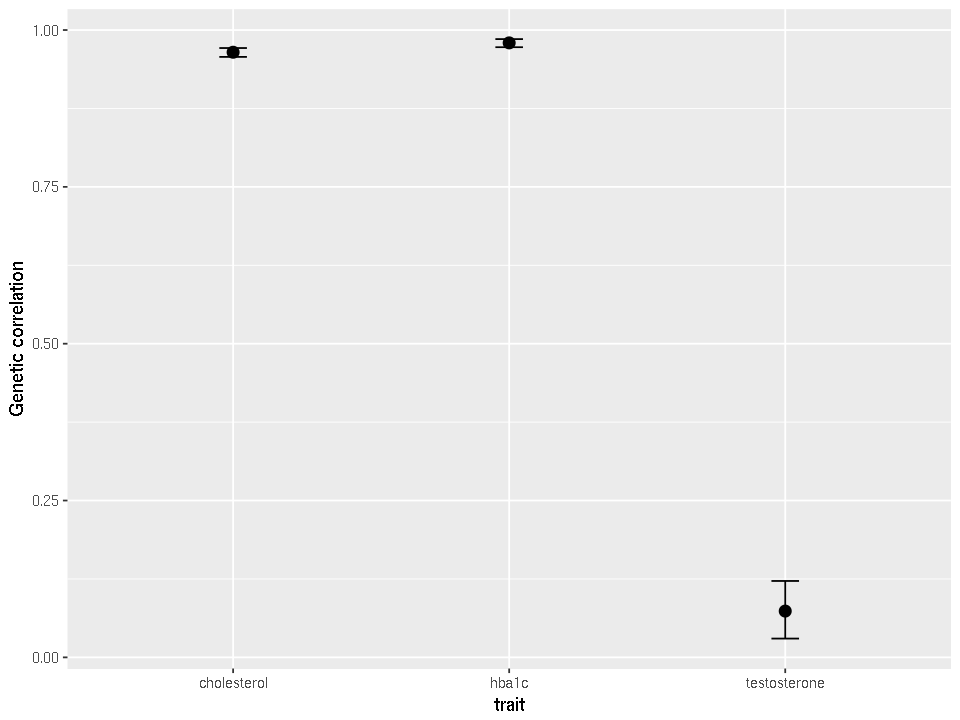

In [47]:
ggplot(trait.df, aes(x=names, y=rg))+geom_errorbar(aes(ymin=rg.l, ymax=rg.u), width=0.1)+geom_point(size=3)+
xlab("trait")+ylab("Genetic correlation")


  

In [36]:
melted_herit <- melt(trait.df[,c("names", "hf", "hm")])

Using names as id variables


names,variable,value
testosterone,hf,0.04674465
hba1c,hf,0.17223152
cholesterol,hf,0.13052704
testosterone,hm,0.11052843
hba1c,hm,0.18259033
cholesterol,hm,0.09703021


Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

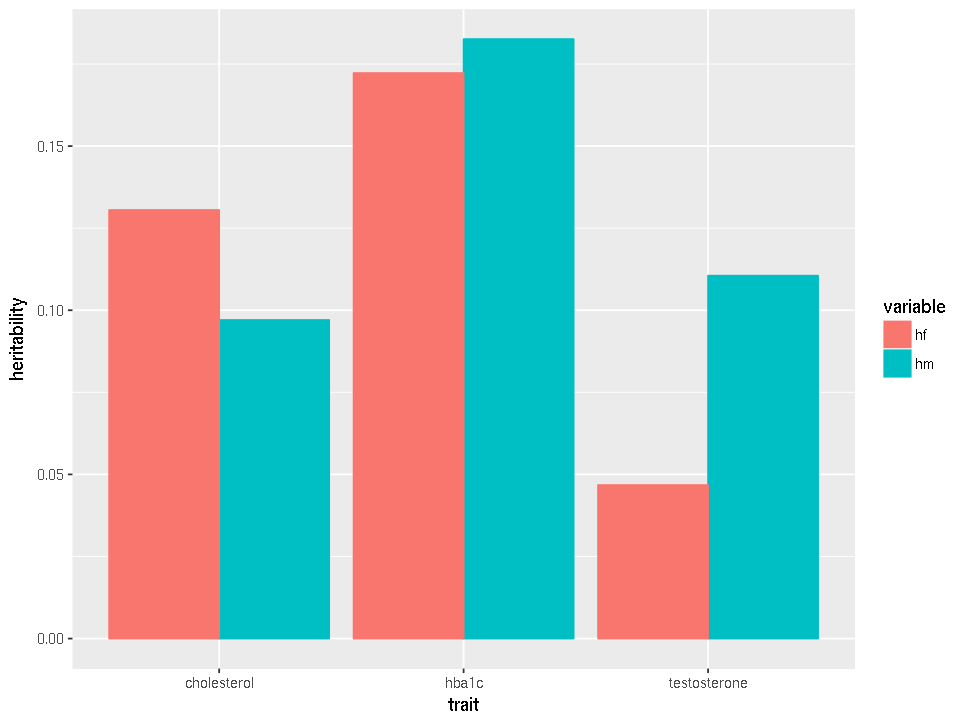

In [48]:
melted_herit
ggplot(melted_herit, aes(x=names, y=value, colour=variable, fill=variable))+geom_histogram(stat="identity", position="dodge")+
xlab("trait")+ylab("heritability")